                                       Machine Learning                                   prof: Delalić Sead       
                                                                                          date: 02.06.2022.


# Project: Find the formula 

## 






In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Ukratko o bibliotekama

 
    
    Pandas je softverska biblioteka napisana za programski jezik Python za manipulaciju i analizu podataka. Konkretno, nudi strukture podataka i operacije za manipulaciju numeričkim tabelama i vremenskim serijama.
    Naziv je izveden od izraza "panel data", pojam u ekonomiji za skupove podataka koji uključuju zapažanja u više vremenskih perioda za iste pojedince.

    Numpy je biblioteka za programski jezik Python, koja dodaje podršku za velike, višedimenzionalne nizove i matrice, zajedno sa velikom kolekcijom matematičkih funkcija visokog nivoa za rad na ovim nizovima.
    
    Seaborn je Python biblioteka za vizualizaciju podataka zasnovana na matplotlib-u. Pruža interfejs visokog nivoa za crtanje atraktivnih i informativnih statističkih grafika.
    
    Scikit-learn (poznat kao sklearn) je besplatna softverska biblioteka za mašinsko učenje za programski jezik Python. Posjeduje različite algoritme za klasifikaciju, regresiju i grupisanje uključujući mašine sa vektorima podrške, povećanje gradijenta, k-srednje vrijednosti i DBSCAN, i dizajniran je da interoperiše sa Python numeričkim i naučnim bibliotekama NumPy i SciPy.
    
    Matplotlib je sveobuhvatna biblioteka za kreiranje statičkih, animiranih i interaktivnih vizualizacija u Pythonu.

# Analiza podataka

In [2]:
podaci = pd.read_csv('data.csv')
podaci.columns = podaci.columns.str.strip()
podaci

,slovo,a,b,c,d,e,f
0,C,5.86,11.59,75.54,50.87,11.72,5.578
1,B,5.54,56.06,36.59,76.01,11.08,32.450
2,C,70.21,69.10,47.9,79.92,140.42,7.589
3,C,87.02,56.71,54.21,6.22,174.04,6.210
4,B,25.19,41.91,31.14,100.81,50.38,8.810
...,...,...,...,...,...,...,...
9995,A,5.86,85.91,63.15,22.69,11.72,5.860
9996,B,80.16,98.09,69.2,60.94,160.32,8.322
9997,A,32.30,54.55,40.0,213213116.34,64.6,32.300
9998,A,39.20,28.94,22.67,94.28,78.4,39.200


Učitavanje podataka formata .csv ('Comma Separated Values') u objekat 'podaci' pomoću biblioteke pandas kao 'pd' i funkcije 'read_csv' čime objekat 'podaci' postaje DataFrame. DataFrame je 2-dimenzionalna označena struktura podataka sa kolonama potencijalno različitih tipova.
Zatim uklanjanje praznih mjesta ' ' u nazivima kolona za lakši rad. Te ispis objekta 'podaci' čime dobijamo lijep vizuelni prikaz. Vidimo da postoje 8 kolona pri čemu:

   - prva kolona predstavlja lokacije redova u dataframe-u 'podaci'
   - druga kolona 'slovo' je kolona čiji su podaci tipa 'string' tj. slova 'A', 'B', 'C' i na jednom mjestu, preciznije lokaciji 9960, slovo 'F'. 
   - ostale kolone ('a', 'b', 'c', 'd', 'e' i 'f') su kolone čiji su podaci uglavnom 'float' prirode.
    
Vidimo da imamo 10000 redova sa 7 kolona što čini 70000 podataka.

In [3]:
podaci = podaci.drop(['e'], axis = 1)

Primjećuje se da je kolona 'e' jednaka dupliranoj koloni 'a', te zbog toga mozemo isključiti kolonu 'e' iz dalje analize.

In [4]:
podaci.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   slovo   9996 non-null   object 
 1   a       10000 non-null  float64
 2   b       10000 non-null  float64
 3   c       10000 non-null  object 
 4   d       10000 non-null  object 
 5   f       9997 non-null   float64
dtypes: float64(3), object(3)
memory usage: 2.0 MB


Funkcija info() se koristi za ispis sažetka DataFrame-a u ovo slučaju 'podaci'. Ova metoda ispisuje informacije o DataFrameu uključujući tipove dtype indeksa i dtype-ove kolona, vrijednosti koje nisu nule i korištenje memorije.
Primijetimo da kolone 'c' i 'd' imaju podatke tipa 'object', dok nama trebaju biti tipa 'float'. U narednoj liniji koda pandas funkcijom 'to_numeric' podaci kolona 'c' i 'd' konvertovati u tip 'float64'.

In [5]:
podaci.c = pd.to_numeric(podaci.c, errors = 'coerce')
podaci.d = pd.to_numeric(podaci.d, errors = 'coerce')

podaci.dtypes

slovo     object
a        float64
b        float64
c        float64
d        float64
f        float64
dtype: object

Uočimo da se pojavljuju relativno veliki podaci, kao na primjer u koloni 'd' lokacija '9997' vidimo broj sa devet cifara. To moramo riješiti jer nam takvi podaci (outliers) ugrožavaju ostale podatke u analizi te će doći do nerealnog zaključka. Outliers/Izuzetci su tačke podataka koje leže izvan ukupnog obrasca u distribuciji.
Koristiću IQR metod i boxplot za detekciju i uklanjanje outlier-a.

Jedna uobičajena tehnika za otkrivanje outliera je korištenje IQR (interkvartilni raspon - interquartile range). Q1 je prvi kvartil, Q3 je treći kvartil, a kvartil dijeli uređeni skup podataka u 4 grupe jednake veličine. Drugi kvartil je medijana.

Metoda interkvartilnog raspona definiše vanjske vrijednosti kao vrijednosti veće od Q3 + 1,5 * IQR ili vrijednosti manje od Q1 – 1,5 * IQR.

<AxesSubplot:xlabel='d'>

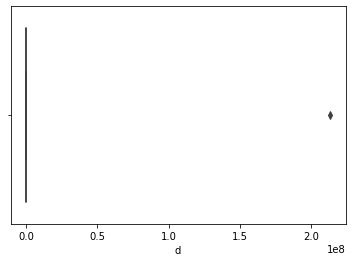

In [6]:
sns.boxplot(x = podaci['d'])

Iz biblioteke saeborn, kao sns, primijenićemo funkciju boxplot() sa kolonom 'd'. Box plot kreirana je da prikaže sažetak skupa vrijednosti podataka koji imaju svojstva kao što su minimum, prvi kvartil, medijan, treći kvartil i maksimum odnosno za vizualizaciju distribucija. Kreira se okvir od prvog kvartila do trećeg kvartila, tu je i horizontalna linija (može biti i verikalna) koja prolazi kroz kutiju na medijani. 

Uočimo outlier na desnoj strani gornje slike u koloni 'd'.

Pa počnimo sa metodom IQR-a. Prvo ćemo prikazati prvi kvartil i treći kvartil.

In [7]:
podaci

,slovo,a,b,c,d,f
0,C,5.86,11.59,75.54,5.087000e+01,5.578
1,B,5.54,56.06,36.59,7.601000e+01,32.450
2,C,70.21,69.10,47.90,7.992000e+01,7.589
3,C,87.02,56.71,54.21,6.220000e+00,6.210
4,B,25.19,41.91,31.14,1.008100e+02,8.810
...,...,...,...,...,...,...
9995,A,5.86,85.91,63.15,2.269000e+01,5.860
9996,B,80.16,98.09,69.20,6.094000e+01,8.322
9997,A,32.30,54.55,40.00,2.132131e+08,32.300
9998,A,39.20,28.94,22.67,9.428000e+01,39.200


In [8]:
podaci['d'].quantile(0.25)

26.115000000000002

In [9]:
podaci['d'].quantile(0.75)

76.16499999999999

Smjestimo kvartile u odgovarajuće varijable, i izračunajmo IQR kao razliku trećeg i prvog kvartila.

In [10]:
Q1 = podaci['d'].quantile(0.25)
Q3 = podaci['d'].quantile(0.75)
IQR = Q3 - Q1
IQR

50.04999999999999

In [11]:
donja_granica = Q1 - 1.5 * IQR
gornja_granica = Q3 + 1.5 * IQR

In [12]:
donja_granica

-48.95999999999999

In [13]:
gornja_granica

151.23999999999998

In [14]:
aut = podaci[(podaci['d'] < donja_granica) | (podaci['d'] > gornja_granica)]
aut

,slovo,a,b,c,d,f
9997,A,32.3,54.55,40.0,2.132131e+08,32.3


Dakle IQR metodom potvrđen je outlier u koloni 'd', gdje smo veliki broj i ranije uočili na lokaciji '9997'. 

In [15]:
print(aut.index[0])

9997


In [16]:
podaci.iloc[9997][4]

213213116.34

In [17]:
podaci.iloc[9997, podaci.columns.get_loc('d')] = np.nan
podaci.iloc[9997]

slovo        A
a         32.3
b        54.55
c         40.0
d          NaN
f         32.3
Name: 9997, dtype: object

In [18]:
outlejeri_donja_granica = (podaci['d'] < donja_granica)
outlejeri_gornja_granica = (podaci['d'] > gornja_granica)
outlejeri_gornja_granica

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: d, Length: 10000, dtype: bool

Ovdje vidimo takođe da nema više izuzetaka na mjestu '9997'.

<AxesSubplot:xlabel='d'>

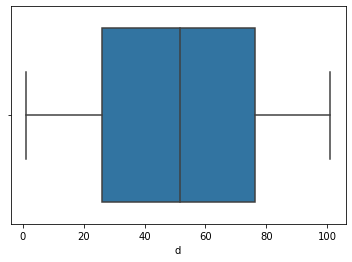

In [19]:
sns.boxplot(x = podaci['d'])

Sada vidimo da je kolona 'd' u dobrom stanju, bez izuzetaka. Primijeniću IQR metodu i na kolone 'a', 'b', 'c' i 'f', odnosno ponoviću identičan postupak detekcije i uklanjanja izuzetaka na pomenute kolone.

<AxesSubplot:xlabel='a'>

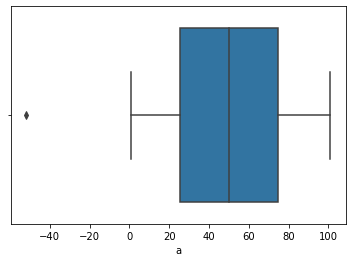

In [20]:
sns.boxplot(x = podaci['a'])

In [21]:
podaci['a'].quantile(0.25)
podaci['a'].quantile(0.75)
Q1 = podaci['a'].quantile(0.25)
Q3 = podaci['a'].quantile(0.75)
IQR = Q3 - Q1

donja_granica = Q1 - 1.5 * IQR
gornja_granica = Q3 + 1.5 * IQR

aut = podaci[(podaci['a'] < donja_granica) | (podaci['a'] > gornja_granica)]
print(aut)


     slovo      a     b      c      d     f
9967     C -52.01  96.2  28.55  81.88  16.9


In [22]:
podaci.iloc[9967, podaci.columns.get_loc('a')] = np.nan
podaci.iloc[9967]

slovo        C
a          NaN
b         96.2
c        28.55
d        81.88
f         16.9
Name: 9967, dtype: object

Uklonjen izuzetak iz kolone 'a' na mjestu '9967' sa NaN

<AxesSubplot:xlabel='a'>

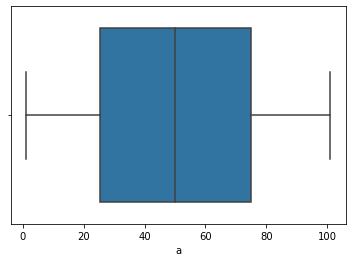

In [23]:
sns.boxplot(x = podaci['a'])

<AxesSubplot:xlabel='b'>

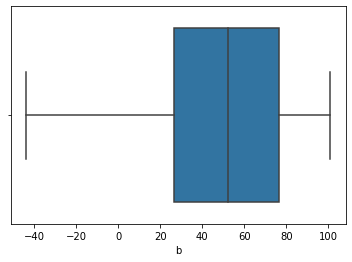

In [24]:
sns.boxplot(x = podaci['b'], )

<AxesSubplot:xlabel='c'>

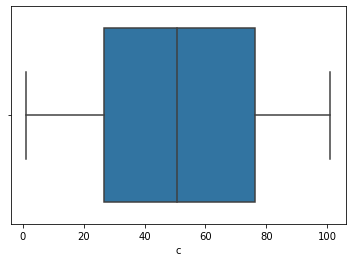

In [25]:
sns.boxplot(x = podaci['c'])

Kolone 'b' i 'c' nemaju drastičnih izuzetaka, pa tu ne moramo primjenjivati IQR metod.

<AxesSubplot:xlabel='f'>

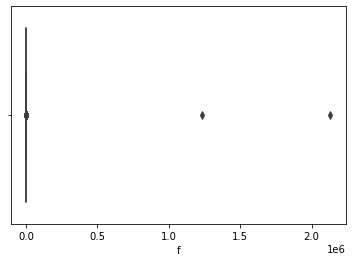

In [26]:
sns.boxplot(x = podaci['f'])

In [27]:
podaci['f'].quantile(0.25)
podaci['f'].quantile(0.75)
Q1 = podaci['f'].quantile(0.25)
Q3 = podaci['f'].quantile(0.75)
IQR = Q3 - Q1

donja_granica = Q1 - 0.3 * IQR
gornja_granica = Q3 + 0.3 * IQR

aut = podaci[(podaci['f'] < donja_granica) | (podaci['f'] > gornja_granica)]
print(aut.iloc[:,:])
print(len(aut))

     slovo      a      b      c      d       f
5        A  63.27  14.55  73.99  94.27  63.270
11       A  94.28  72.36  53.71   9.01  94.280
23       A  49.62  13.17   4.58  49.63  49.620
24       A  50.23  28.93  55.18   7.41  50.230
26       A  78.79  71.37  19.35  83.42  78.790
...    ...    ...    ...    ...    ...     ...
9981     A  91.85  40.39  19.77  32.30  91.850
9985     C   3.36  98.98  67.75  47.61  87.520
9988     A  52.78  96.18   1.62  29.48  52.780
9990     C   1.96  82.94  75.26  50.26  92.236
9991     A  55.54  52.06   2.30  34.92  55.540

[2035 rows x 6 columns]
2035


In [28]:
for i in range(1, len(aut) + 1):
    podaci.iloc[i, podaci.columns.get_loc('f')] = np.nan

In [29]:
podaci

,slovo,a,b,c,d,f
0,C,5.86,11.59,75.54,50.87,5.578
1,B,5.54,56.06,36.59,76.01,NaN
2,C,70.21,69.10,47.90,79.92,NaN
3,C,87.02,56.71,54.21,6.22,NaN
4,B,25.19,41.91,31.14,100.81,NaN
...,...,...,...,...,...,...
9995,A,5.86,85.91,63.15,22.69,5.860
9996,B,80.16,98.09,69.20,60.94,8.322
9997,A,32.30,54.55,40.00,NaN,32.300
9998,A,39.20,28.94,22.67,94.28,39.200


<AxesSubplot:xlabel='f'>

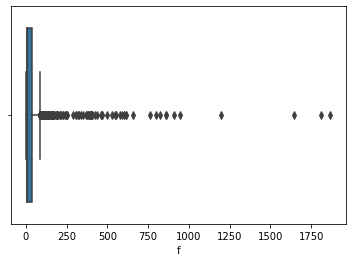

In [30]:
sns.boxplot(x = podaci['f'])

# Separating Data Frame

In [31]:
X = podaci.iloc[:,:-1].values
y = podaci.iloc[:,-1:].values

Ovdje ćemo razdvojiti naš dataframe 'podaci' na NumPy objekte X i y. 

.iloc su lokacije indeksa od nula pa nadalje u originalnom dataframe-u 'podaci' i one se čuvaju iako kasnije slijedi razdvajanje na -train- i -test-, dakle ostaće iste lokacije indeksa.
Metoda .values vraća vrijednosti iz nekog rečnika, niza. Želimo da dobijemo obične matrice.

In [32]:
X

array([['C', 5.86, 11.59, 75.54, 50.87],
       ['B', 5.54, 56.06, 36.59, 76.01],
       ['C', 70.21, 69.1, 47.9, 79.92],
       ...,
       ['A', 32.3, 54.55, 40.0, nan],
       ['A', 39.2, 28.94, 22.67, 94.28],
       ['A', 11.8, 38.51, 2.15, 82.47]], dtype=object)

In [33]:
y

array([[ 5.578],
       [   nan],
       [   nan],
       ...,
       [32.3  ],
       [39.2  ],
       [11.8  ]])

In [34]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer.fit(X[:, 1:])
X[:, 1:] = imputer.transform(X[:, 1:])
imputer.fit(y)
y = imputer.transform(y)

Klasom SimpleImputer zamijeniti će se sva NotANumber mjesta sa 'mean' odnosno koristeći srednju vrijednost duž svake kolone.

In [35]:
X

array([['C', 5.86, 11.59, 75.54, 50.87],
       ['B', 5.54, 56.06, 36.59, 76.01],
       ['C', 70.21, 69.1, 47.9, 79.92],
       ...,
       ['A', 32.3, 54.55, 40.0, 51.16059129564782],
       ['A', 39.2, 28.94, 22.67, 94.28],
       ['A', 11.8, 38.51, 2.15, 82.47]], dtype=object)

In [36]:
y

array([[ 5.578     ],
       [28.93944312],
       [28.93944312],
       ...,
       [32.3       ],
       [39.2       ],
       [11.8       ]])

In [37]:
for i in range(0, len(y)):
    if ((X[i][0] != 'A') and (X[i][0] != 'B') and (X[i][0] != 'C') and (X[i][0] != 'F')):
           print("Index razlicito od slova je: ", i)

Index razlicito od slova je:  428
Index razlicito od slova je:  432
Index razlicito od slova je:  433
Index razlicito od slova je:  484


Ponjavanje prazih mjesta u koloni 'slovo' sa NaN vrijednosti.

In [38]:
X[419][0] = np.nan
X[422][0] = np.nan
X[423][0] = np.nan
X[473][0] = np.nan

Od ukupno 9864 podataka, 9860 su slova dok su preostala 4 prazna mjesta. 

In [39]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
imputer.fit(X[:, 0:1])
X[:, 0:1] = imputer.transform(X[:, 0:1])

Ovim smo sa najučestalijim slovom ispunili np.nan mjesta u koloni 'slovo'.

#### Kodiranje kolone 'slovo'

In [40]:
ct = ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder = 'passthrough')

Ulaz za ovaj transformator bi trebao biti niz cijelih brojeva ili nizova, koji označava vrijednosti koje preuzimaju kategoričke (diskretne) karakteristike. Karakteristike su kodirane korištenjem one-hot šeme kodiranja. Ovo stvara binarnu kolonu za svaku kategoriju i vraća rijetku matricu ili gusti niz.

In [41]:
X = ct.fit_transform(X)
X[0]

array([0.0, 0.0, 1.0, 0.0, 5.86, 11.59, 75.54, 50.87], dtype=object)

### Train Test Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train

array([[1.0, 0.0, 0.0, ..., 86.27, 6.69, 59.54],
       [0.0, 0.0, 1.0, ..., 99.33, 1.35, 55.71],
       [0.0, 0.0, 1.0, ..., 82.19, 36.08, 51.15],
       ...,
       [0.0, 0.0, 1.0, ..., 81.54, 97.85, 57.48],
       [0.0, 0.0, 1.0, ..., 89.98, 58.85, 31.1],
       [0.0, 1.0, 0.0, ..., 3.19, 8.49, 11.95]], dtype=object)

Procedura train-test split se koristi za procjenu performansi algoritama mašinskog učenja kada se koriste za predviđanje podataka koji se ne koriste za obuku modela. Train-test split dijeli nizove ili matrice u nasumični trening i test podskupove.

In [43]:
sc = StandardScaler()
X_train[:,7:] = sc.fit_transform(X_train[:,7:])
X_test[:,7:] = sc.transform(X_test[:,7:])

StandardScaler obavlja zadatak standardizacije. Obično skup podataka sadrži varijable koje se razlikuju po mjerilu. Za npr. skup podataka o zaposlenicima će sadržavati kolonu 'godine' sa vrijednostima na skali 20-70 i kolonu 'plata' sa vrijednostima na skali 10000-80000.
Kako su ove dvije kolone različite po mjerilu, one su standardizirane da imaju zajedničku skalu prilikom izgradnje modela mašinskog učenja.

In [44]:
X_train

array([[1.0, 0.0, 0.0, ..., 86.27, 6.69, 0.28408931503090595],
       [0.0, 0.0, 1.0, ..., 99.33, 1.35, 0.151380443057501],
       [0.0, 0.0, 1.0, ..., 82.19, 36.08, -0.006622809213707165],
       ...,
       [0.0, 0.0, 1.0, ..., 81.54, 97.85, 0.21271065282066715],
       [0.0, 0.0, 1.0, ..., 89.98, 58.85, -0.7013520215026812],
       [0.0, 1.0, 0.0, ..., 3.19, 8.49, -1.3648963813697064]],
      dtype=object)

In [45]:
X_test

array([[0.0, 0.0, 1.0, ..., 83.73, 51.59, 0.006197630115316455],
       [0.0, 1.0, 0.0, ..., 88.6, 76.58, 0.2764663511055407],
       [0.0, 1.0, 0.0, ..., 7.49, 19.15, 0.5061947639472315],
       ...,
       [1.0, 0.0, 0.0, ..., 24.03, 61.26, -0.4906810184744038],
       [1.0, 0.0, 0.0, ..., 18.13, 28.49, 0.439667078780407],
       [0.0, 1.0, 0.0, ..., 93.49, 24.48, 0.3880388231040692]],
      dtype=object)

In [46]:
y_test

array([[27.442     ],
       [ 8.521     ],
       [28.93944312],
       ...,
       [51.26      ],
       [28.93944312],
       [44.405     ]])

# Computing accuracy

### Linearni regresor

In [47]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [48]:
predictions = model.predict(X_test)
predictions

array([[30.22633433],
       [21.70597511],
       [19.7585514 ],
       ...,
       [36.33809372],
       [44.74262827],
       [38.68929943]])

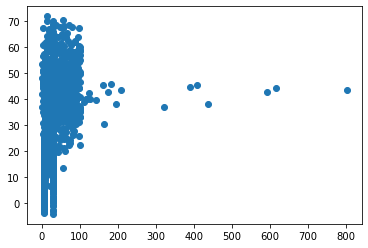

In [49]:
plt.scatter(y_test, predictions)
plt.show()

In [50]:
greska = 0
for i in range(len(predictions)):
    greska += predictions[i] + y_test[i]

print(greska/(len(predictions)))

[57.20833927]


Greska je ~57.208

In [51]:
mse = mean_squared_error(y_test, predictions)
mse

1347.3546952114161

Mean Absolute Error je prosječna greška svih apsolutnih grešaka.

In [52]:
rmse = np.sqrt(mse)
rmse

36.706330451455045

Root Mean Squared Error nam govori koliko su podaci udaljeni od najbolje linije.   

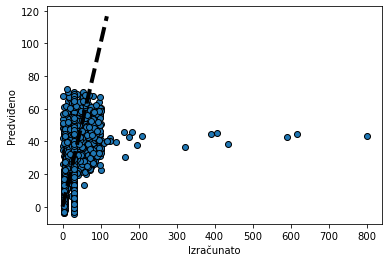

In [53]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors = (0, 0, 0))
ax.plot([y.min()/16, y.max()/16], [y.min()/16, y.max()/16], "k--", lw = 4)
ax.set_xlabel("Izračunato")
ax.set_ylabel("Predviđeno")
plt.show()

### Lasso regresor  

In [54]:
lasso_reg = Lasso(alpha = 1)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=1)

In [55]:
predictions = lasso_reg.predict(X_test)
predictions

array([30.85119676, 23.80931364, 21.76731339, ..., 33.66567067,
       41.48562756, 40.55990637])

In [56]:
greska = 0
for i in range(len(predictions)):
    greska += predictions[i] + y_test[i]

print(greska/(len(predictions)))

[57.21842179]


In [57]:
mse = mean_squared_error(y_test, predictions)
print(mse)
rmse = np.sqrt(mse)
rmse

1352.5851619948378


36.77750891502628

Takođe, koristivši Lasso regresor, dobijamo malo bolje rezultate.

### Polinomijalni regresor

In [58]:
poly = PolynomialFeatures(2)
poly_reg_model = LinearRegression()

In [59]:
poly_features = poly.fit_transform(X_test)

In [60]:
poly_reg_model.fit(poly_features, y_test)

LinearRegression()

In [61]:
predictions = poly_reg_model.predict(poly_features)
predictions

array([[43.2898407 ],
       [ 9.53886414],
       [ 9.53927612],
       ...,
       [38.74756241],
       [37.94254303],
       [81.11859131]])

In [62]:
greska = 0
for i in range(len(predictions)):
    greska += predictions[i] + y_test[i]

print(greska/(len(predictions)))

[55.4307068]


In [63]:
mse = mean_squared_error(y_test, predictions)
print(mse)
rmse = np.sqrt(mse)
rmse

924.2103137472034


30.400827517473985

Polinomijalna regresija daje bolje rezultate u odnosu na prethodne regresore.

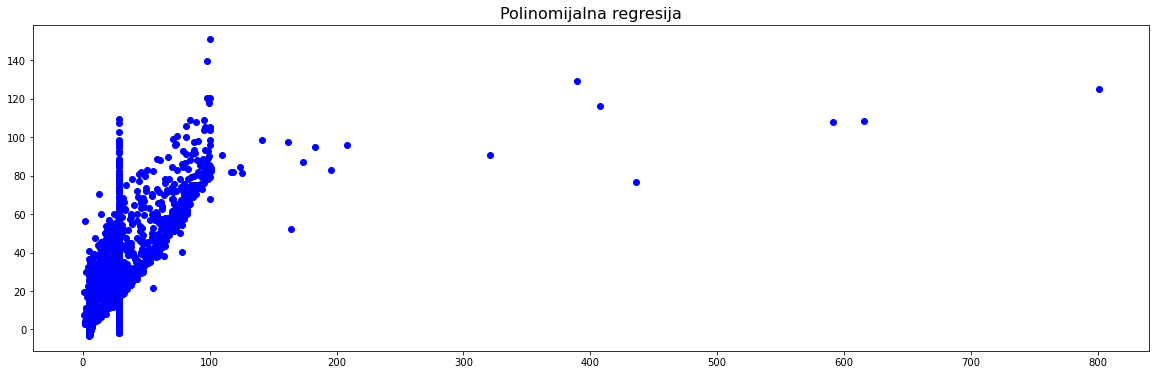

In [64]:
plt.figure(figsize = (20, 6))
plt.title("Polinomijalna regresija", size = 16)
plt.scatter(y_test, predictions, c = "blue")
plt.show()

                                                                                        student: Amina Dacić
                                                                                        index: 5574/M